In [ ]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt


df = pd.read_csv("Linear Acceleration.csv")
dm = pd.read_csv('Location.csv')


,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
0,0.021880,0.003529,-0.011756,-0.015967
1,0.029877,0.098076,-0.030871,-0.006975
2,0.037871,0.087998,-0.000519,-0.028808
3,0.045868,0.111318,0.080899,-0.051458
4,0.053864,0.072379,0.120572,-0.088598


In [93]:
#Suodatettu data

def butter_lowpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = 'low', analog=False)
    y = filtfilt(b,a,data)
    return y

def butter_highpass_filter(data, cutoff, fs, nyq, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

#Filttereiden parametrit
T = df['Time (s)'][len(df['Time (s)'])-1]-df['Time (s)'][0] # Koko datan pituus
n = len(df['Time (s)']) #Datapisteiden lukumäärä
fs = n/T #Näytteenottotaajuus
nyq = fs/2 #Nyqvistin taajuus
order = 3 #Kertaluku
cutoff = 1 /(0.2) # Cutt-off taajuus


df['filter_a_x'] = butter_lowpass_filter(df['Linear Acceleration x (m/s^2)'], cutoff, fs, nyq, order)
df['filter_a_y'] = butter_lowpass_filter(df['Linear Acceleration y (m/s^2)'], cutoff, fs, nyq, order)
df['filter_a_z'] = butter_lowpass_filter(df['Linear Acceleration z (m/s^2)'], cutoff, fs, nyq, order)

In [94]:
#Askelmäärä laskettuna suodatetusta kiihtyvyysdatasta
df['acc_magnitude'] = np.sqrt(df['filter_a_x']**2 + df['filter_a_y']**2 + df['filter_a_z']**2)
peaks,_ = find_peaks(df['acc_magnitude'], height=0.5, distance=10)
step_count = len(peaks)
print(f"Askelmäärä: {step_count}")


Askelmäärä: 1805


In [ ]:
#Askelmäärä laskettuna kiihtyvyysdatasta Fourier-analyysin perusteella
t = df['Time (s)']
dz = df['filter_a_z']

N = len(dz)
dt = t.iloc[1] - t.iloc[0]
fourier = np.fft.fft(dz,N)


frequencies = np.fft.fftfreq(N, dt)

magnitude = np.abs(fourier)


Times = df['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0]



dominant_freq = frequencies[np.argmax(magnitude[:N//2])]

step_count = Times * dominant_freq
print(f"Askelmäärä Fourier-analyysin avulla: {step_count}")

1: [ 0.          0.00247306  0.00494612 ... -0.00741918 -0.00494612
 -0.00247306]
2: [10261.11861099  1030.70581706  1156.10174742 ...  2948.56490179
  1156.10174742  1030.70581706]
3: 404.56798699200004
Askelmäärä Fourier-analyysin avulla: 0.0


In [81]:
# Kuljettu matka (GPS-datasta) ja keskinopeus (GPS-datasta)

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1)* cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

dm['dist'] = np.zeros(len(dm))
dm['time_diff'] = np.zeros(len(dm))


for i in range(len(dm)-1):
    dm.loc[i,'dist'] = haversine(dm['Longitude (°)'][i], dm['Latitude (°)'][i], dm['Longitude (°)'][i+1], dm['Latitude (°)'][i+1])*1000
    dm.loc[i,'time_diff'] = dm['Time (s)'][i+1]- dm['Time (s)'][i]

total_distance = dm['dist'].sum() 
total_time = dm['time_diff'].sum() 
average_speed = total_distance / total_time 

print(f"Kokonaismatka: {total_distance:.2f} m")
print(f"Keskinopeus: {average_speed:.2f} m/s")



Kokonaismatka: 436.03 m
Keskinopeus: 1.08 m/s


In [68]:

# Askelpituus (lasketun askelmäärän ja matkan perusteella)

step_length = total_distance / step_count

print(f"Askelpituus: {step_length:.2f} m")


Askelpituus: 0.24 m


In [ ]:
# Kuvaajia;

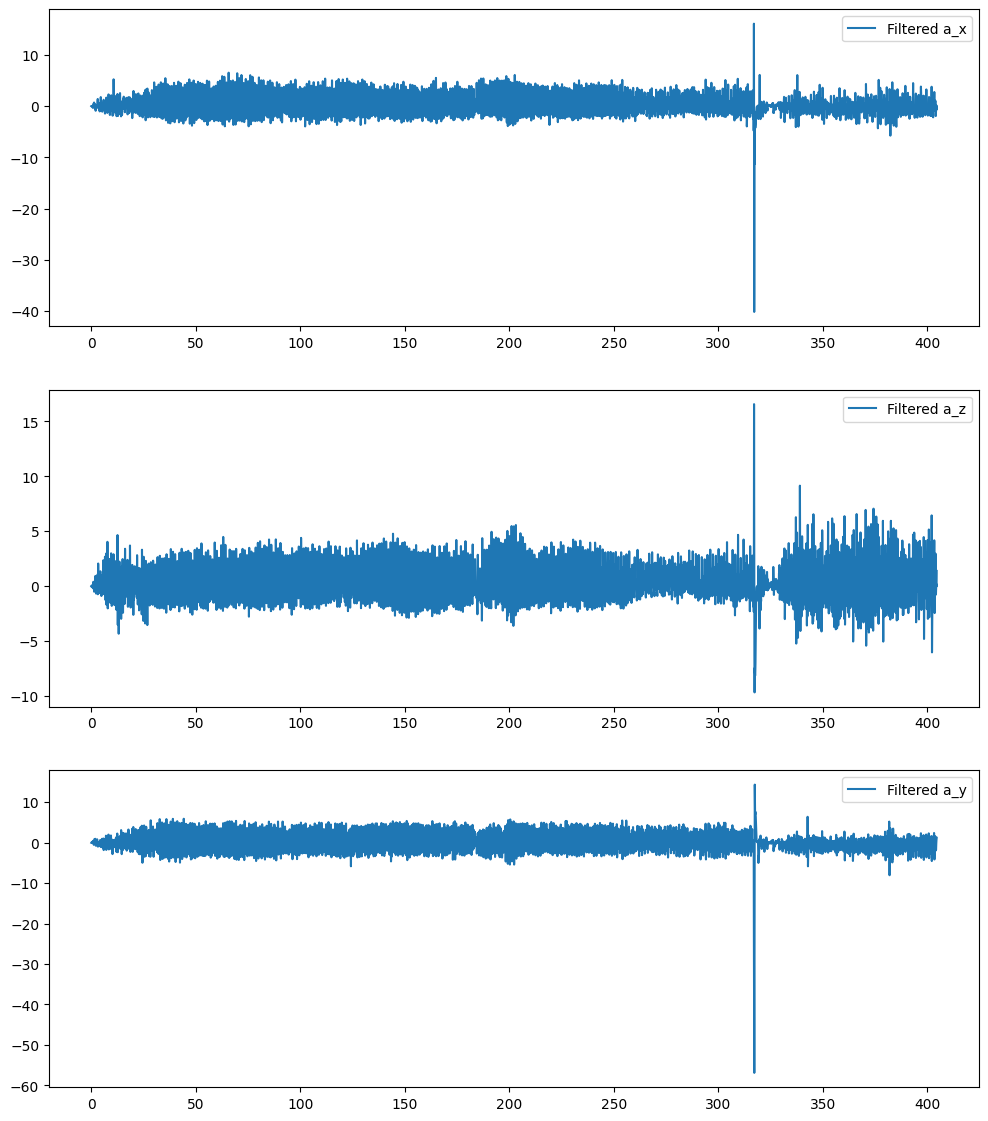

In [42]:
# Suodatettu kiihtyvyysdata x-komponentti
plt.figure(figsize=(12,14))
plt.subplot(3,1,1)
plt.plot(df['Time (s)'],df['filter_a_x'])
plt.legend(['Filtered a_x'])

# Suodatettu kiihtyvyysdata z-komponentti

plt.subplot(3,1,2)
plt.plot(df['Time (s)'],df['filter_a_z'])
plt.legend(['Filtered a_z'])


# Suodatettu kiihtyvyysdata y-komponentti

plt.subplot(3,1,3)
plt.plot(df['Time (s)'],df['filter_a_y'])
plt.legend(['Filtered a_y'])


In [ ]:
# Analyysiin valitun kiihtyvyysdatan komponentin tehospektritiheys



In [48]:
# Reitti kartalla

import folium

start_lat = dm['Latitude (°)'].mean()
start_long = dm['Longitude (°)'].mean()
my_map = folium.Map(location = [start_lat,start_long], zoom_start = 14)

folium.PolyLine(dm[['Latitude (°)','Longitude (°)']],color = 'red', weight = 2.5, opacity = 1).add_to(my_map)

my_map.save('fysiikka_lopputyo.html')
my_map